# Train Bayer-to-RGB

In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from torch import nn
import torchvision
from torchvision import transforms
import ai8x
import torch.optim as optim
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as trans
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data.dataloader import DataLoader as LoadData
import torch.optim as optim
from torch.utils.data import Dataset
import cv2
from skimage import io
import torchvision

%matplotlib inline

In [2]:
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

In [3]:
def Bayer_filter(img):
    out =  np.zeros(shape=[img.shape[0],img.shape[1],1],dtype=img.dtype)
    for j in range(1,img.shape[1],2):
        for i in range(0,img.shape[0],2):
            out[i,j] = img[i, j, 2]
    for j in range(0,img.shape[1],2):
        for i in range(0,img.shape[0],2):
            out[i,j] = img[i, j, 1]
    for j in range(1,img.shape[1],2):
        for i in range(1,img.shape[0],2):
            out[i,j] = img[i, j, 1]
    for j in range(0,img.shape[1],2):
        for i in range(1,img.shape[0],2):
            out[i,j] = img[i, j, 0]
    return out

In [4]:
def fold_data(img, fold_ratio=2):
    img_folded = None
    for i in range(fold_ratio):
        for j in range(fold_ratio):
            img_subsample = img[i::fold_ratio, j::fold_ratio, :]
            if img_folded is not None:
                img_folded = np.concatenate((img_folded, img_subsample), axis=2)
            else:
                img_folded = img_subsample
                
    return img_folded

In [5]:
# Set Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(f'Device: {device}')

Device: cuda:0


In [6]:
# Set hardware device
ai8x.set_device(device=87, simulate=False, round_avg=False)

Configuring device: MAX78002, simulate=False.


In [7]:
args = Args(act_mode_8bit=False)

(720, 960, 3)


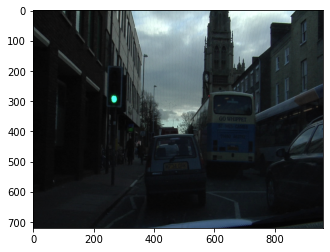

In [10]:
sample_inp = cv2.imread("/data/raw/CamVid_All/CamVid/test/0001TP_006690.png")
sample_inp = cv2.cvtColor(sample_inp, cv2.COLOR_BGR2RGB)
print(sample_inp.shape)
plt.imshow(sample_inp)
plt.show()

In [11]:
sample_inp_bayer = Bayer_filter(sample_inp)
print(sample_inp_bayer.shape)

sample_inp_bayer_folded = fold_data(sample_inp_bayer)
sample_inp_bayer_folded = (torch.Tensor(sample_inp_bayer_folded).permute([2,0,1]).unsqueeze(0) - 128.) / 128.

(720, 960, 1)


In [12]:
l1 = ai8x.Conv2d(4, 3, kernel_size=1, padding=0, bias = False)
l2 = ai8x.ConvTranspose2d(3, 3, kernel_size=3, padding=1, stride=2)

In [13]:
#Initialize Weights
l1.op.weight.data[0, :, 0, 0] = torch.tensor([0, 0, 1, 0])
l1.op.weight.data[1, :, 0, 0] = torch.tensor([0.5, 0, 0, 0.5])
l1.op.weight.data[2, :, 0, 0] = torch.tensor([0, 1, 0, 0])
l1.op.weight.data.shape

torch.Size([3, 4, 1, 1])

In [14]:
l1_out = l1(sample_inp_bayer_folded)

torch.Size([1, 3, 360, 480]) tensor(-1., grad_fn=<MinBackward1>) tensor(0.9922, grad_fn=<MaxBackward1>)
(360, 480, 3) 0 255


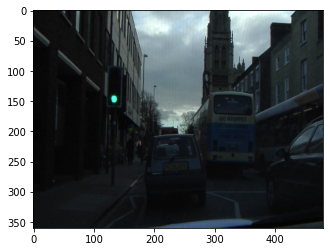

In [15]:
print(l1_out.shape, l1_out.min(), l1_out.max())
l1_out_np = 128*(l1_out[0].detach().numpy().transpose(1,2,0)+1)
l1_out_np = l1_out_np.astype(np.uint8)
print(l1_out_np.shape, l1_out_np.min(), l1_out_np.max())
plt.imshow(l1_out_np)
plt.show()

In [ ]:
class bayer_filter:
    def __call__(self, img):
        img = np.array(img)
        out =  np.zeros(shape=[img.shape[0],img.shape[1],1],dtype=img.dtype)
        for j in range(1,img.shape[1],2):
            for i in range(0,img.shape[0],2):
                out[i,j] = img[i, j, 2]
        for j in range(0,img.shape[1],2):
            for i in range(0,img.shape[0],2):
                out[i,j] = img[i, j, 1]
        for j in range(1,img.shape[1],2):
            for i in range(1,img.shape[0],2):
                out[i,j] = img[i, j, 1]
        for j in range(0,img.shape[1],2):
            for i in range(1,img.shape[0],2):
                out[i,j] = img[i, j, 0]
        return out

In [ ]:
class fold_data():
    def __call__(self, img):
        img_folded = None
        fold_ratio=2
        for i in range(fold_ratio):
            for j in range(fold_ratio):
                img_subsample = img[i::fold_ratio, j::fold_ratio, :]
                if img_folded is not None:
                    img_folded = np.concatenate((img_folded, img_subsample), axis=2)
                else:
                    img_folded = img_subsample
                
        return img_folded

In [ ]:
transform = transforms.Compose([transforms.Resize((128,128)),
            transforms.ToTensor(),
            ai8x.normalize(args=args),
        ])
transform2 = transforms.Compose([transforms.Resize((128,128)),bayer_filter(),fold_data(),
            transforms.ToTensor(),
            ai8x.normalize(args=args),
        ])

train_dir = '/data_ssd/ImageNet/val'

In [ ]:
class Bayer(Dataset):
    def __init__(self, image_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform
        self.dataset = torchvision.datasets.ImageFolder(root=os.path.join(self.image_dir))
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        targets = self.target_transform(image)
        data = self.transform(image)
        return data, targets

In [ ]:
dataset = Bayer(image_dir=train_dir,transform=transform2,target_transform=transform)
train_dataset = LoadData(dataset, batch_size=16, shuffle=True)
dataset

# conv w/fold + transconv

In [ ]:
class bayer2rgbnet(nn.Module):
    def __init__(self):
        super(bayer2rgbnet,self).__init__()
        self.l1 = ai8x.Conv2d(4, 3, kernel_size=1, padding=0, bias=False)
        self.l2 = ai8x.ConvTranspose2d(3, 3, kernel_size=3, padding=1, stride=2, bias=False)
        self._init_layers()

    def _init_layers(self):
        #Initialize Weights
        self.l1.op.weight.data[0, :, 0, 0] = torch.tensor([0, 0, 1, 0])
        self.l1.op.weight.data[1, :, 0, 0] = torch.tensor([0.5, 0, 0, 0.5])
        self.l1.op.weight.data[2, :, 0, 0] = torch.tensor([0, 1, 0, 0])
        self.l1.op.weight.requires_grad = False

    def forward(self,x):
        x = self.l1(x)
        x = self.l2(x)
        return x

# conv w/fold + transconv + conv

In [ ]:
class bayer2rgbnet(nn.Module):
    def __init__(self):
        super(bayer2rgbnet,self).__init__()
        self.l1 = ai8x.Conv2d(4, 3, kernel_size=1, padding=0, bias=False)
        self.l2 = ai8x.ConvTranspose2d(3, 3, kernel_size=3, padding=1, stride=2, bias=False)
        self.l3 = ai8x.Conv2d(3, 3, kernel_size=3, padding=1, bias=False)
        self._init_layers()

    def _init_layers(self):
        #Initialize Weights
        self.l1.op.weight.data[0, :, 0, 0] = torch.tensor([0, 0, 1, 0])
        self.l1.op.weight.data[1, :, 0, 0] = torch.tensor([0.5, 0, 0, 0.5])
        self.l1.op.weight.data[2, :, 0, 0] = torch.tensor([0, 1, 0, 0])
        self.l1.op.weight.requires_grad = False

    def forward(self,x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x

# conv w/fold + b2rgbnet

In [ ]:
class bayer2rgbnet(nn.Module):
    def __init__(self):
        super(bayer2rgbnet,self).__init__()
        self.l1 = ai8x.Conv2d(4, 3, kernel_size=1, padding=0, bias=False)
        self.l2 = ai8x.ConvTranspose2d(3, 3, kernel_size=3, padding=1, stride=2, bias=False)
        self.l3 = ai8x.Conv2d(3, 3, kernel_size=3, padding=1, bias=False)
        self.conv1 = ai8x.FusedConv2dReLU(3, 16, 3, padding=1)
        self.conv1_2 = ai8x.FusedConv2dReLU(16, 32, 3, padding=1)
        self.conv1_3 = ai8x.FusedConv2dReLU(32, 64, 3, padding=1)
        self.conv1_4 = ai8x.FusedConv2dReLU(64, 128, 3, padding=1)
        self.conv2 = ai8x.FusedConv2dReLU(128, 64, 1, padding=0)
        self.conv3 = ai8x.FusedConv2dReLU(64, 32, 3, padding=1)
        self.conv3_2 = ai8x.Conv2d(32, 3, 3, padding=1)
        self._init_layers()

    def _init_layers(self):
        #Initialize Weights
        self.l1.op.weight.data[0, :, 0, 0] = torch.tensor([0, 0, 1, 0])
        self.l1.op.weight.data[1, :, 0, 0] = torch.tensor([0.5, 0, 0, 0.5])
        self.l1.op.weight.data[2, :, 0, 0] = torch.tensor([0, 1, 0, 0])
        self.l1.op.weight.requires_grad = False

    def forward(self,x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.conv1(x)
        x = self.conv1_2(x)
        x = self.conv1_3(x)
        x = self.conv1_4(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv3_2(x)
        return x

# Bayer-to-RGB

In [ ]:
model = bayer2rgbnet().to(device)

model.train()

learning_rate = 1e-2
l_model = True
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr= learning_rate) 

loss_values=[]
test_accuracy_values=[]

for epoch in range(1): 
    loss_ep = 0

    for batch_idx, (data,targets) in enumerate(train_dataset):
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
        if(batch_idx>0 and batch_idx%100 == 0):
            print(batch_idx)
            print(f"Loss in epoch {epoch} :::: {loss_ep/batch_idx}")
            scores_np = 128*(scores[0].cpu().detach().numpy().transpose(1,2,0)+1)
            scores_np = scores_np.astype(np.uint8)
            plt.imshow(scores_np)
            plt.show()

    loss_values.append(loss_ep / len(train_dataset))
        
    print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dataset)}")

# Bilinear Interpolation

In [ ]:
transform = transforms.Compose([transforms.Resize((128,128)),
            transforms.ToTensor(),
            ai8x.normalize(args=args),
        ])
transform_unfold = transforms.Compose([transforms.Resize((128,128)),bayer_filter(),
            transforms.ToTensor(),
            ai8x.normalize(args=args),
        ])

criterion = nn.MSELoss()

dataset_unfold = Bayer(image_dir=train_dir,transform=transform_unfold,target_transform=transform)
train_dataset_unfold = LoadData(dataset_unfold, batch_size=1, shuffle=True)

loss_values=[]
loss_ep = 0

for batch_idx, (data,targets) in enumerate(train_dataset_unfold):
    
    out_tensor = torch.zeros_like(targets)
    img = 128*(data[0].cpu().detach().numpy().transpose(1,2,0)+1)
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img,cv2.COLOR_BayerGR2RGB)
    out_tensor = torch.Tensor(((img.transpose(2,0,1).astype(np.float32))/128-1)).to(device)
    targets = targets.to(device)
    loss = criterion(out_tensor,targets[0])
    loss_ep += loss.item()
    if(batch_idx != 0 and batch_idx % 10000 ==0):
        loss_values.append(loss_ep / batch_idx)
        print(loss_values)
      
loss_values.append(loss_ep / len(train_dataset_unfold))
